In [1]:
from zipfile import ZipFile
import glob, os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import fnmatch
import datetime as dt
from statistics import median
from matplotlib.ticker import PercentFormatter
from matplotlib import font_manager as fm
from matplotlib.gridspec import GridSpec
from matplotlib import ticker as ticker
from datetime import datetime, timedelta
import datetime
import dask.dataframe as dd
import locale

In [2]:
zip_files=glob.glob('Bases/*.zip')
extracted_files=glob.glob('*.csv')
#zip_files
num_files=len(zip_files)
#print(extracted_files)

DATOS DESCARGADOS DESDE https://www.gob.mx/salud/documentos/datos-abiertos-152127

# OBTENER INFORMACIÓN

## Extracción de Archivos Zip

In [3]:
file_name=zip_files[0]
file_name=file_name.split("Bases\\")[1].split(".zip",1)[0]
#file_name

for f in range(num_files):
    #print(f)
    file=zip_files[f]
    with ZipFile (file,"r") as zf:
        
        ##GET FILE NAME
        file_name=zf.namelist()
        #print(file_name)
        
        ##SEARCH IF THE FILE WAS ALREADY EXTRACTED BEFORE
        if file_name[0] in extracted_files:
            next
            #print(str(file_name) + "already extracted")
        
        ##IF THE FILE WAS NOT EXTRACTED BEFORE, THEN EXTRACT AND NOTICE
        else:
            #print("added" + str(file_name))
            zf.extractall()
            extracted_files=glob.glob('*.csv')

## Carga de Bases de Datos 

### Catálogos 

In [4]:
Catalogos=pd.ExcelFile("diccionario_datos_covid19/Catalogos_0412.xlsx")
#Catalogos.sheet_names

### Descriptores

In [5]:
descriptores=pd.read_excel("diccionario_datos_covid19/Descriptores_0419.xlsx")

#Eliminar acentos en Descriptores[Formato o Fuente]
descriptores["FORMATO O FUENTE"]=descriptores["FORMATO O FUENTE"].str.replace("Á","A")
descriptores["FORMATO O FUENTE"]=descriptores["FORMATO O FUENTE"].str.replace("Ó","O")
descriptores["NOMBRE DE VARIABLE"]=descriptores["NOMBRE DE VARIABLE"].str.replace("OTRAS_COM","OTRA_COM")
#descriptores

#Definir tipos de columnas

dtypes={"ID_REGISTRO":"object","MUNICIPIO_RES":"object","PAIS_NACIONALIDAD":"object","PAIS_ORIGEN":"object",
       "INTUBADO":"uint8","NEUMONIA":"uint8","EMBARAZO":"uint8","HABLA_LENGUA_INDIG":"uint8","DIABETES":"uint8",
        "EPOC":"uint8","ASMA":"uint8","INMUSUPR":"uint8","HIPERTENSION":"uint8","OTRA_COM":"uint8","UCI":"uint8",
        "CARDIOVASCULAR":"uint8","OBESIDAD":"uint8","RENAL_CRONICA":"uint8","TABAQUISMO":"uint8","OTRO_CASO":"uint8",
        "TIPO_PACIENTE":"uint8","ORIGEN":"uint8","SECTOR":"uint8","ENTIDAD_UM":"uint8","SEXO":"uint8",
        "ENTIDAD_NAC":"uint8","ENTIDAD_RES":"uint8","MIGRANTE":"uint8","NACIONALIDAD":"uint8","EDAD":"uint8",
        "RESULTADO":"uint8","NACIONALIDAD":"uint8"}

#col_fechas=["FECHA_ACTUALIZACION"]

### Bases de Datos 

In [6]:
#Cargar todas las bases de datos en una sola

for f in range(len(extracted_files)):
    if f == 0:
        current_file_name=extracted_files[f]
        
        #total_dbs=pd.read_csv(current_file_name,dtype=dtypes)
        ddbs=dd.read_csv(current_file_name,dtype=dtypes)
        
        fecha_real="20"+current_file_name[0:2]+"-"+current_file_name[2:4]+"-"+current_file_name[4:6]
        
        #Sustituye la Fecha_Actualizacion con la Fecha en el nombre del archivo
        #total_dbs["FECHA_ACTUALIZACION"]=fecha_real
        ddbs=ddbs.assign(FECHA_ACTUALIZACION=fecha_real)
        
    else:
        current_file_name=extracted_files[f]
        
        #current_file=pd.read_csv(current_file_name,encoding='latin-1',dtype=dtypes,parse_dates=col_fechas)
        current_file=dd.read_csv(current_file_name, parse_dates=["FECHA_ACTUALIZACION"],dtype=dtypes,encoding="latin-1")       
        
        fecha_real="20"+current_file_name[0:2]+"-"+current_file_name[2:4]+"-"+current_file_name[4:6]
        
        #Sustituye la Fecha_Actualizacion con la Fecha en el nombre del archivo
        current_file=current_file.assign(FECHA_ACTUALIZACION=fecha_real)
        #current_file["FECHA_ACTUALIZACION"]=fecha_real
        
        ddbs=ddbs.append(current_file)
        #print(current_file_name)

total_dbs=ddbs.compute()
del ddbs

#Comprobación de bases cargads
reportes=total_dbs.FECHA_ACTUALIZACION.unique()
#reportes

#total_dbs.tail()

### Descripción de claves

In [8]:
total_dbs_columns=list(total_dbs.columns)

origen=[]
sector=[]
sexo=[]
tipo_paciente=[]
si_no=[]
nacionalidad=[]
resultado=[]
entidades=[]
municipios=[]

#Selección de catálogo a utilizar por columna
total_dbs_columns=list(total_dbs.columns)

for c in range (len(total_dbs_columns)):
    #print(c)
    #print(total_dbs_columns[c])
    
    #Determina información en Columna Formato Fuente
    rFoF=descriptores.loc[descriptores["NOMBRE DE VARIABLE"]==total_dbs_columns[c],["FORMATO O FUENTE"]]
    #print(rFoF)
    FoF=rFoF["FORMATO O FUENTE"][c]
    
    #Si la información contiene Catalogo, entonces hace búsqueda del catálogo para traducir la información
    if "CATALOGO" in FoF:
        cat = rFoF["FORMATO O FUENTE"][c].split(": ",1)[1]
        cat=str(cat.replace(" ",""))
        #print(cat)
        
        if cat == "ORIGEN":
            origen.append(total_dbs_columns[c])
            #print(ORIGEN)
            
        elif cat == "SECTOR":
            sector.append(total_dbs_columns[c])
            #print(SECTOR)
            
        elif cat =="SEXO":
            sexo.append(total_dbs_columns[c])
            #print(SEXO)
        
        elif cat =="TIPO_PACIENTE":
            tipo_paciente.append(total_dbs_columns[c])
            #print(TIPO_PACIENTE)
            
        elif cat =="SI_NO":
            si_no.append(total_dbs_columns[c])
            #print(SI_NO)
        
        elif cat=="NACIONALIDAD":
            nacionalidad.append(total_dbs_columns[c])
            #print(NACIONALIDAD)
        
        elif cat=="RESULTADO":
            resultado.append(total_dbs_columns[c])
            #print(RESULTADO)
            
        elif cat=="ENTIDADES":
            entidades.append(total_dbs_columns[c])
            #print(ENTIDADES)
        
        elif cat=="MUNICIPIOS":
            municipios.append(total_dbs_columns[c])
            #print(MUNICIPIOS)

#### Valores variables 
Información de aquéllas variables que normalmente deberían cambiar conforme evoluciona el caso

In [9]:
catalogos_variables=[tipo_paciente,si_no,resultado]
nombre_catalogos_variables=["TIPO_PACIENTE","SI_NO","RESULTADO"]

evolucion=["TIPO_PACIENTE","FECHA_INGRESO","FECHA_SINTOMAS","FECHA_DEF","INTUBADO","NEUMONIA","RESULTADO","UCI"]

#### Varlores fijos 
Información que normalmente no debería cambiar. Cualquier cambio se asume como una actualización de información faltante o errónea. La información presente en el último reporte disponible se tomará como válida.

In [10]:
catalogos_fijos=[origen,sector,sexo,nacionalidad,entidades,municipios]
nombre_catalogos_fijos=["ORIGEN","SECTOR","SEXO","NACIONALIDAD","ENTIDADES","MUNICIPIOS"]

identificacion=['ORIGEN', 'SECTOR', 'ENTIDAD_UM','SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES','EDAD',
                'NACIONALIDAD', 'HABLA_LENGUA_INDIG','MIGRANTE', 'PAIS_NACIONALIDAD','PAIS_ORIGEN']
comorbilidades=['EMBARAZO','DIABETES','EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM','CARDIOVASCULAR', 'OBESIDAD',
                'RENAL_CRONICA', 'TABAQUISMO']

Descartar columnas de valores fijos

In [11]:
db_tiempo=total_dbs.drop(columns=['ORIGEN', 'SECTOR', 'ENTIDAD_UM','SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES',
                                  'EDAD','NACIONALIDAD', 'HABLA_LENGUA_INDIG','MIGRANTE', 'PAIS_NACIONALIDAD','PAIS_ORIGEN',
                        'EMBARAZO','DIABETES','EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM','CARDIOVASCULAR',
                        'OBESIDAD','RENAL_CRONICA', 'TABAQUISMO','OTRO_CASO'])
#db_tiempo.head()

In [12]:
for col in range(len(si_no)):
    #print(si_no[col])
    try:
        db_tiempo[si_no[col]]=db_tiempo[si_no[col]].str.strip()
    except:
        print("Not Found: " + si_no[col])

Not Found: INTUBADO
Not Found: NEUMONIA
Not Found: EMBARAZO
Not Found: HABLA_LENGUA_INDIG
Not Found: DIABETES
Not Found: EPOC
Not Found: ASMA
Not Found: INMUSUPR
Not Found: HIPERTENSION
Not Found: OTRA_COM
Not Found: CARDIOVASCULAR
Not Found: OBESIDAD
Not Found: RENAL_CRONICA
Not Found: TABAQUISMO
Not Found: OTRO_CASO
Not Found: MIGRANTE
Not Found: UCI


In [13]:
#Descripción de códigos variables en el tiempo
for cv in range(len(catalogos_variables)):
    sheet="Catálogo "+ str(nombre_catalogos_variables[cv])
    catalogo = catalogos_variables[cv]
    
    dbcat=pd.read_excel("diccionario_datos_covid19/Catalogos_0412.xlsx",sheet_name=sheet)

    try:
        #print("try" + str(sheet))
        keys=dbcat["CLAVE"].tolist()
    
    except:
        dbcat=pd.read_excel("diccionario_datos_covid19/Catalogos_0412.xlsx",sheet_name=sheet,skiprows=1)
        keys=dbcat["CLAVE"].tolist()
        
    values=dbcat["DESCRIPCIÓN"].tolist()
    dictionary = dict(zip(keys, values))

    try:
        for col in range(len(catalogo)):
            db_tiempo[catalogo[col]]=db_tiempo[catalogo[col]].map(dictionary)
            db_tiempo.loc[:,catalogo]=db_tiempo[catalogo].astype("category")
            #print(total_dbs[catalogo[col]].unique())
            
    except:
        pass

#db_tiempo.dtypes

In [14]:
#Formato de fechas
db_tiempo["FECHA_ACTUALIZACION"]=pd.to_datetime(db_tiempo["FECHA_ACTUALIZACION"].str.strip(), format="%Y-%m-%d")
db_tiempo["FECHA_SINTOMAS"]=pd.to_datetime(db_tiempo["FECHA_SINTOMAS"].str.strip(), format="%Y-%m-%d")
db_tiempo["FECHA_DEF"]=pd.to_datetime(db_tiempo["FECHA_DEF"].str.strip(), format="%Y-%m-%d", errors="coerce")
#total_dbs["FECHA_ACTUALIZACION"].unique()

In [15]:
#Fechas
fecha_primer_reporte=min(reportes)
fecha_ultimo_reporte=max(reportes)
susana_distancia=datetime.datetime(2020, 3, 23)
nueva_normalidad=datetime.datetime(2020, 6, 1)

# EVOLUCIÓN EN EL TIEMPO

R1 = Primer Reporte en el cual aparece el ID

R2 = Primer Reporte en el cual se tiene un resultado (positivo o negativo)

R3 = Primer Reporte en el cual se registra fecha de defunción

RX = Último Reporte generado

Rt = Consolidado de reportes (R1, R2, R3, RX) con base en el último reporte

## Información de los casos reportados en el último reporte (Rx)

Identificación de casos: ID_REGISTRO, FECHA_SINTOMAS

In [16]:
#Obtener estado actual del caso
Rx = db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","FECHA_SINTOMAS","RESULTADO",
               "TIPO_PACIENTE","INTUBADO","UCI","FECHA_DEF"]]

#Obtener registros con Fecha de Actualización del último reporte
Rx = Rx.loc[Rx["FECHA_ACTUALIZACION"]==fecha_ultimo_reporte]



#Renombrar columnas para identificar la información obtenida del último reporte
Rx = Rx.rename(columns={"RESULTADO":"RX_RESULTADO","TIPO_PACIENTE":"RX_TIPO_PACIENTE",
                        "INTUBADO":"RX_INTUBADO","UCI":"RX_UCI","FECHA_ACTUALIZACION":"RX_FECHA"})

#Rx.head()

In [17]:
#Último reporte como base para reporte consolidado
Rt=Rx
total_registros=Rt.shape[0]
total_positivos=Rt.loc[Rt["RX_RESULTADO"]=="Positivo SARS-CoV-2"].shape[0]
total_negativos=Rt.loc[Rt["RX_RESULTADO"]=="No positivo SARS-CoV-2"].shape[0]
total_pendientes=Rt.loc[Rt["RX_RESULTADO"]=="Resultado pendiente"].shape[0]
total_defunciones=Rt.loc[(Rt["RX_RESULTADO"]=="Positivo SARS-CoV-2") & (Rt["FECHA_DEF"].notnull())].shape[0]

total_registros='{:,}'.format(total_registros)
total_positivos='{:,}'.format(total_positivos)
total_negativos='{:,}'.format(total_negativos)
total_pendientes='{:,}'.format(total_pendientes)
total_defunciones='{:,}'.format(total_defunciones)

In [18]:
#Comprobación 1
print("Total Registros: " + str(total_registros))
print("Total Positivos: " + str(total_positivos))
print("Total Negativos: "+ str(total_negativos))
print("Total Pendientes: " + str(total_pendientes))
print("Total Defunciones COVID: " + str(total_defunciones))

Total Registros: 1,516,588
Total Positivos: 668,381
Total Negativos: 765,337
Total Pendientes: 82,870
Total Defunciones COVID: 70,821


## Información del primer reporte (R1)
Obtener información del reporte donde se registra por primera vez cada ID que existe en el últimpo reporte.

In [19]:
#Obtener información de identificación de cada caso
R1 = db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","FECHA_SINTOMAS"]]

#Obtener primera fecha en la cual aparece cada ID
R1 = R1.groupby(["ID_REGISTRO","FECHA_SINTOMAS"], as_index=False).min()

R1 = R1.rename(columns={"FECHA_ACTUALIZACION":"R1_FECHA"})

#Primer Resultado registrado y Tipo paciente
aux_R1=db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","RESULTADO","TIPO_PACIENTE"]]

R1 = R1.merge(aux_R1,left_on=["ID_REGISTRO","R1_FECHA"],
              right_on=["ID_REGISTRO","FECHA_ACTUALIZACION"],how="left")

R1=R1.rename(columns={"RESULTADO":"R1_RESULTADO","TIPO_PACIENTE":"R1_TIPO_PACIENTE"})

R1=R1.loc[:,["ID_REGISTRO","R1_FECHA","R1_RESULTADO","R1_TIPO_PACIENTE","FECHA_SINTOMAS"]]

#Días transcurridos entre que el paciente declara sentir síntomas y el registro del caso (T1)
R1["T1"]=(R1["R1_FECHA"]-R1["FECHA_SINTOMAS"]).dt.days

#Rango de días entre que el paciente declara sentir síntomas y el registro del caso
t1_rango=[min(R1["T1"]),4,9,14,max(R1["T1"])]
t1_etiqueta=("0 - 4", "5 - 9","10 - 14", "15+")

R1["T1_RANGO"]=pd.cut(R1["T1"],t1_rango,labels=t1_etiqueta)

R1=R1.sort_values(by="R1_FECHA")

In [20]:
#Obtener resultados registrados en el primer reporte

primer_reporte=R1.loc[R1["R1_FECHA"] ==fecha_primer_reporte]
registros_primer_reporte=primer_reporte["ID_REGISTRO"].count()
#registros_primer_reporte='{:,}'.format(registros_primer_reporte)

covid_primer_reporte=(primer_reporte.loc[primer_reporte["R1_RESULTADO"]=="Positivo SARS-CoV-2","ID_REGISTRO"]).count()
#covid_primer_reporte='{:,}'.format(covid_primer_reporte)

nocovid_primer_reporte=primer_reporte.loc[primer_reporte["R1_RESULTADO"]=="No positivo SARS-CoV-2","ID_REGISTRO"].count()
#nocovid_primer_reporte='{:,}'.format(nocovid_primer_reporte)

pendientes_primer_reporte=primer_reporte.loc[primer_reporte["R1_RESULTADO"]=="Resultado pendiente","ID_REGISTRO"].count()
#pendientes_primer_reporte='{:,}'.format(pendientes_primer_reporte)

print("Registros primer reporte: "+str(registros_primer_reporte))
print("Registros positivos primer reporte: "+str(covid_primer_reporte))
print("Registros negativos reporte: "+str(nocovid_primer_reporte))
print("Registros pendientes reporte: "+str(pendientes_primer_reporte))

Registros primer reporte: 36594
Registros positivos primer reporte: 4661
Registros negativos reporte: 23236
Registros pendientes reporte: 8697


In [21]:
#Agregar la información del primer reporte (R1) al consolidado de bases (Rt)
Rt=Rt.merge(R1,on=["ID_REGISTRO","FECHA_SINTOMAS"],how="left")

In [22]:
#Comprobación 2
Rt.groupby(["RX_RESULTADO"], as_index=False)["ID_REGISTRO","FECHA_DEF"].count()

,RX_RESULTADO,ID_REGISTRO,FECHA_DEF
0,No positivo SARS-CoV-2,765337,17488
1,Positivo SARS-CoV-2,668381,70821
2,Resultado pendiente,82870,2142


## Información del primer reporte con resultado (R2)

In [23]:
#Primer reporte en el cual aparece el ID con resultado de prueba (Positivo o No Positivo)

R2 = db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","RESULTADO","FECHA_SINTOMAS"]]
R2 = R2.loc[R2["RESULTADO"]!="Resultado pendiente",:]
R2 = R2.groupby(["ID_REGISTRO","FECHA_SINTOMAS"],as_index=False).min()
R2 = R2.rename(columns={"FECHA_ACTUALIZACION":"R2_FECHA"})

#Tipo paciente y resultado cuando se obtuvo el resultado de la prueba
aux_R2 = db_tiempo.loc[:,["ID_REGISTRO","TIPO_PACIENTE","RESULTADO","FECHA_ACTUALIZACION","FECHA_SINTOMAS"]]

R2=R2.merge(aux_R2,left_on=["ID_REGISTRO","R2_FECHA","FECHA_SINTOMAS"],
            right_on=["ID_REGISTRO","FECHA_ACTUALIZACION","FECHA_SINTOMAS"])

R2=R2.loc[:,["ID_REGISTRO","R2_FECHA","TIPO_PACIENTE","RESULTADO","FECHA_SINTOMAS"]]
R2 = R2.rename(columns={"TIPO_PACIENTE":"R2_TIPO_PACIENTE","RESULTADO":"R2_RESULTADO"})

#R2.head()

In [24]:
#Agregar la información del primer reporte con resultado (R2) al consolidado de bases (Rt)
Rt=Rt.merge(R2,on=["ID_REGISTRO","FECHA_SINTOMAS"],how="left")

In [25]:
#Determinar los días transcurridos entre que se registró el caso (se asume se hizo la examen de COVID) y se obtuvo
#un resultado (Positivo o Negativo a SARS-CoV-2)

Rt["T2"]=(Rt["R2_FECHA"]-Rt["R1_FECHA"]).dt.days

t2_rango=[-1,3,7,14,max(Rt["T2"])]
t2_etiqueta=("0 - 3", "4 - 7","8 - 14", "15+")

Rt["T2_RANGO"]=pd.cut(Rt["T2"],t2_rango,labels=t2_etiqueta)

#Rt.head()

In [26]:
#Comprobación 3
Rt.groupby(["RX_RESULTADO","R2_RESULTADO"],as_index=False)["ID_REGISTRO","FECHA_DEF"].count()

,RX_RESULTADO,R2_RESULTADO,ID_REGISTRO,FECHA_DEF
0,No positivo SARS-CoV-2,No positivo SARS-CoV-2,763516.0,17408.0
1,No positivo SARS-CoV-2,Positivo SARS-CoV-2,1821.0,80.0
2,No positivo SARS-CoV-2,Resultado pendiente,NaN,NaN
3,Positivo SARS-CoV-2,No positivo SARS-CoV-2,3374.0,461.0
4,Positivo SARS-CoV-2,Positivo SARS-CoV-2,665007.0,70360.0
5,Positivo SARS-CoV-2,Resultado pendiente,NaN,NaN
6,Resultado pendiente,No positivo SARS-CoV-2,88.0,14.0
7,Resultado pendiente,Positivo SARS-CoV-2,87.0,7.0
8,Resultado pendiente,Resultado pendiente,NaN,NaN


## Información de Defunciones (R3)

In [27]:
#R3 Primer Reporte en el cual se registra fecha de defunción

R3=db_tiempo.loc[total_dbs["FECHA_DEF"]!="9999-99-99"]
R3=R3.loc[:,["FECHA_ACTUALIZACION","ID_REGISTRO","FECHA_DEF","FECHA_SINTOMAS"]]
R3=R3.groupby(["ID_REGISTRO","FECHA_DEF","FECHA_SINTOMAS"],as_index=False).min()

aux_R3=db_tiempo.loc[:,["ID_REGISTRO","FECHA_ACTUALIZACION","RESULTADO","TIPO_PACIENTE","FECHA_SINTOMAS"]]

R3 = R3.merge(aux_R3,on=["ID_REGISTRO","FECHA_SINTOMAS","FECHA_ACTUALIZACION"],how="left")

R3=R3.rename(columns={"RESULTADO":"R3_RESULTADO","TIPO_PACIENTE":"R3_TIPO_PACIENTE", "FECHA_ACTUALIZACION":"R3_FECHA"})

R3=R3.loc[:,["ID_REGISTRO","R3_FECHA","R3_RESULTADO","R3_TIPO_PACIENTE","FECHA_SINTOMAS","FECHA_DEF"]]

#R3.head()

In [28]:
#Agregar la información del primer reporte con resultado (R3) al consolidado de bases (Rt)
Rt=Rt.merge(R3,on=["ID_REGISTRO","FECHA_SINTOMAS","FECHA_DEF"],how="left")

In [29]:
#Determinar los días transcurridos entre la fecha de defunción y el primer reporte donde se especifica FECHA_DEF
Rt["T3"]=(Rt["R3_FECHA"]-Rt["FECHA_DEF"]).dt.days

t3_rango=[-1,7,14,21,np.nanmax(Rt["T3"])]
t3_etiquetas=("1 semana", "2 semana","3 semanas", "+3 semanas")

Rt["T3_RANGO"]=pd.cut(Rt["T3"],t3_rango,labels=t3_etiquetas)

#Determinar los días transcurridos entre la Fecha de Defunción y la fecha de registro del caso
Rt["T4"] = (Rt["FECHA_DEF"]-Rt["R1_FECHA"]).dt.days 

t4_rango=[np.nanmin(Rt["T3"]),1,7,14,21,np.nanmax(Rt["T3"])]
t4_etiquetas=("Def antes de registro","1 semana", "2 semana","3 semanas", "+3 semanas")
Rt["T4_RANGO"]=pd.cut(Rt["T4"],t4_rango,labels=t4_etiquetas)

#Determinar los días transcurridos entre la fecha de Defunción y la fecha de Sítomas
Rt["T5"]=(Rt["FECHA_DEF"]-Rt["FECHA_SINTOMAS"]).dt.days
t5_rango=[0,3,7,14,21,30,np.nanmax(Rt["T5"])]
t5_etiquetas=("3 días","1 semana","2 semanas","3 semanas","1 mes","+1 mes")

Rt["T5_RANGO"]=pd.cut(Rt["T5"],t5_rango,labels=t5_etiquetas)

In [30]:
#Comprobación 4
Rt.groupby(["RX_RESULTADO"],as_index=False)["ID_REGISTRO","FECHA_DEF"].count()

,RX_RESULTADO,ID_REGISTRO,FECHA_DEF
0,No positivo SARS-CoV-2,765337,17488
1,Positivo SARS-CoV-2,668381,70821
2,Resultado pendiente,82870,2142


# ANÁLISIS DEFUNCIONES

In [31]:
defunciones=Rt.loc[:,["ID_REGISTRO","FECHA_DEF","FECHA_SINTOMAS","RX_RESULTADO",
                                                  "R1_FECHA","R2_FECHA","R3_FECHA",
                                                  "T1","T2","T3","T4","T5",
                                                  "T1_RANGO","T2_RANGO","T3_RANGO","T4_RANGO","T5_RANGO"]]
#defunciones["FECHA_DEF"].count()

In [32]:
defunciones_covid=Rt.loc[(Rt["RX_RESULTADO"]=="Positivo SARS-CoV-2") & (Rt["FECHA_DEF"].notnull())]
defunciones_nocovid=defunciones.loc[defunciones["RX_RESULTADO"]=="No positivo SARS-CoV-2"]
defunciones_pendientes=defunciones.loc[defunciones["RX_RESULTADO"]=="Resultado pendiente"]

In [33]:
#Comprobación 5
defunciones_covid["ID_REGISTRO"].count()

70821

## Defunciones por fecha de defunción (FECHA_DEF)

In [34]:
def_covid_fecha=defunciones_covid.loc[:,["FECHA_DEF","ID_REGISTRO"]]
def_covid_fecha=def_covid_fecha.groupby(["FECHA_DEF"],as_index=False).count()

In [35]:
#Comprobación 6
def_covid_fecha["ID_REGISTRO"].sum()

70821

In [36]:
#Cuándo fue registrada la fecha de defunción
covid_def_fecha=defunciones_covid.loc[:,["FECHA_DEF","ID_REGISTRO","T3_RANGO"]]
covid_def_fecha=covid_def_fecha.groupby(["FECHA_DEF","T3_RANGO"],as_index=False).count()
covid_def_fecha=covid_def_fecha.rename(columns={"ID_REGISTRO":"NUM_COVID_DEF_FECHA"})

covid_def_fecha=covid_def_fecha.pivot(index='FECHA_DEF', columns='T3_RANGO', values='NUM_COVID_DEF_FECHA').rename_axis(None, axis=1)
covid_def_fecha=covid_def_fecha.rename(columns=str).reset_index()
covid_def_fecha=covid_def_fecha.fillna(0)

covid_def_fecha["TOTAL"]=covid_def_fecha["1 semana"]+covid_def_fecha["2 semana"]+covid_def_fecha["3 semanas"]+covid_def_fecha["+3 semanas"]

covid_def_fecha["%1 sem"]=covid_def_fecha["1 semana"]/covid_def_fecha["TOTAL"]*100
covid_def_fecha["%2 sem"]=covid_def_fecha["2 semana"]/covid_def_fecha["TOTAL"]*100
covid_def_fecha["%3 sem"]=covid_def_fecha["3 semanas"]/covid_def_fecha["TOTAL"]*100
covid_def_fecha["%+3 sem"]=covid_def_fecha["+3 semanas"]/covid_def_fecha["TOTAL"]*100

## Defunciones por fecha de defunción (R3)

In [37]:
def_covid_R3=defunciones_covid.loc[:,["R3_FECHA","ID_REGISTRO"]]
def_covid_R3=def_covid_R3.groupby(["R3_FECHA"],as_index=False).count()

#Cuándo fue registrada la fecha de defunción
covid_R3=defunciones_covid.loc[:,["R3_FECHA","ID_REGISTRO","T3_RANGO"]]
covid_R3=covid_R3.groupby(["R3_FECHA","T3_RANGO"],as_index=False).count()
covid_R3=covid_R3.rename(columns={"ID_REGISTRO":"NUM_COVID_R3"})

#Se descarta primer reporte, dado que los casos con resultado negativo son el acumulado hasta esta fecha
#Considera casos reportados ya con resultado Negativo como casos pendientes que posteriormente tendrán resultado negativo

covid_R3=covid_R3.pivot(index='R3_FECHA', columns='T3_RANGO', values='NUM_COVID_R3').rename_axis(None, axis=1)
covid_R3=covid_R3.rename(columns=str).reset_index()
covid_R3=covid_R3.fillna(0)

covid_R3["TOTAL_R3"]=covid_R3["1 semana"]+covid_R3["2 semana"]+covid_R3["3 semanas"]+covid_R3["+3 semanas"]

#covid_R3.head(10)

In [38]:
def_covid_T3=defunciones_covid.loc[:,["R3_FECHA","ID_REGISTRO","T3_RANGO"]]
def_covid_T3=def_covid_T3.groupby(["R3_FECHA","T3_RANGO"],as_index=False).count()
def_covid_T3=def_covid_T3.rename(columns={"ID_REGISTRO":"DEFUNCIONES_T3"})

#Descartar primer reporte
def_covid_T3=def_covid_T3.loc[def_covid_T3["R3_FECHA"]!=fecha_primer_reporte]

def_covid_T3=def_covid_T3.pivot(index="R3_FECHA",columns="T3_RANGO",values="DEFUNCIONES_T3").rename_axis(None, axis=1)

def_covid_T3=def_covid_T3.rename(columns=str).reset_index()
def_covid_T3=def_covid_T3.fillna(0)

def_covid_T3["TOTAL"]=def_covid_T3["1 semana"]+def_covid_T3["2 semana"]+def_covid_T3["3 semanas"]+def_covid_T3["+3 semanas"]

def_covid_T3["%1 sem"]=def_covid_T3["1 semana"]/def_covid_T3["TOTAL"]*100
def_covid_T3["%2 sem"]=def_covid_T3["2 semana"]/def_covid_T3["TOTAL"]*100
def_covid_T3["%3 sem"]=def_covid_T3["3 semanas"]/def_covid_T3["TOTAL"]*100
def_covid_T3["%+3 sem"]=def_covid_T3["+3 semanas"]/def_covid_T3["TOTAL"]*100

#def_covid_T3.head(10)

## DEFUNCIONES SEMANA 33, NOTIFICACIONES SEMANA 35

In [39]:
#Calcular el cambio semanal, con el último reporte disponible, de las defunciones ocurridas entre la semanas 32 y 33
def_sem_32=Rx.loc[(Rx["FECHA_DEF"]>"2020-08-01")&(Rx["FECHA_DEF"]<"2020-08-09")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_33=Rx.loc[(Rx["FECHA_DEF"]>"2020-08-08")&(Rx["FECHA_DEF"]<"2020-08-16")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
#sem_33=(def_covid_T3["R3_FECHA"]>"2020-08-08")&(def_covid_T3["R3_FECHA"]<"2020-08-16")
#sem_35=(def_covid_T3["R3_FECHA"]>"2020-08-22")&(def_covid_T3["R3_FECHA"]<"2020-08-30")


print("Defunciones Semana 32: "+str(def_sem_32)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 33: "+str(def_sem_33)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 33/32: " + str("{:.2%}".format(def_sem_33/def_sem_32-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")

Defunciones Semana 32: 3957 (hasta el reporte del 2020-09-13)
Defunciones Semana 33: 3495 (hasta el reporte del 2020-09-13)
Cambio número defunciones Sem 33/32: -11.68% (hasta el reporte del 2020-09-13)


In [40]:
def_sem_33_bd=covid_def_fecha.loc[(covid_def_fecha["FECHA_DEF"]>"2020-08-08")&(covid_def_fecha["FECHA_DEF"]<"2020-08-16")]

In [41]:
total_covid_def_fecha=covid_def_fecha.loc[:,["1 semana","2 semana","3 semanas","+3 semanas","TOTAL"]]
total_covid_def_fecha.sum()

1 semana      51365.0
2 semana       7782.0
3 semanas      3821.0
+3 semanas     7853.0
TOTAL         70821.0
dtype: float64

C:\Users\varicoj\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


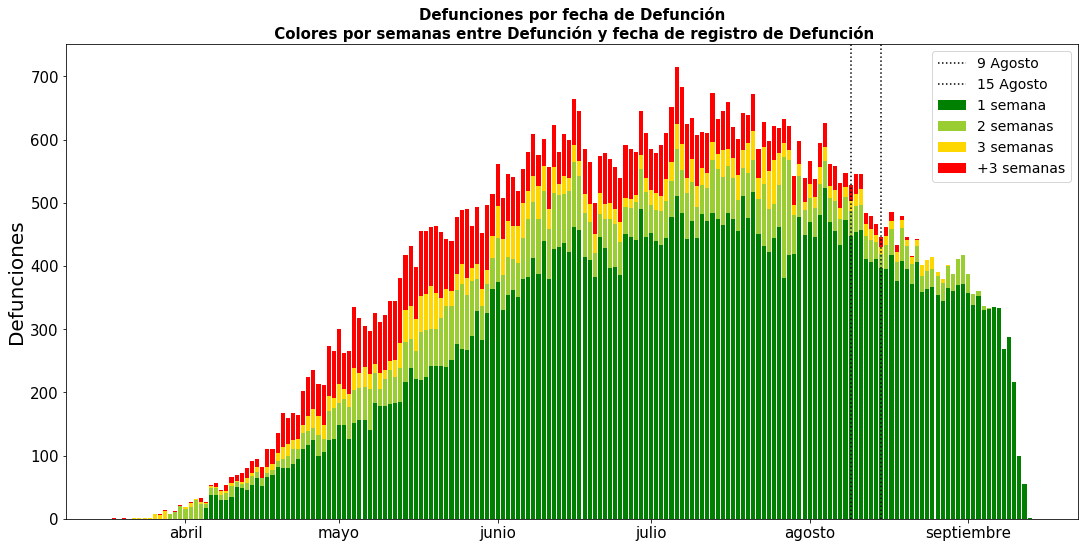

'Spanish_Mexico.1252'

In [42]:
locale.setlocale(locale.LC_ALL, 'es-MX')
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(1, 1, figure=fig)

#DEFUNCIONES POR FECHA DE NOTIFICACIÓN DE DEFUNCIÓN

ax1 = fig.add_subplot(gs[0, 0])

y5=covid_def_fecha["1 semana"]
y6=covid_def_fecha["2 semana"]
y7=covid_def_fecha["3 semanas"]
y8=covid_def_fecha["+3 semanas"]

aux_y5y6=np.add(covid_def_fecha["1 semana"],covid_def_fecha["2 semana"]).tolist()
aux_y5y6y7=np.add(aux_y5y6,covid_def_fecha["3 semanas"]).tolist()


x5=covid_def_fecha["FECHA_DEF"]

#ax5 = fig.add_subplot(gs[0, 0:2])

ax1.bar(x5,y5,color="green",label="1 semana")
ax1.bar(x5,y6,color="yellowgreen",bottom=y5,label="2 semanas")
ax1.bar(x5,y7,color="gold",bottom=aux_y5y6,label="3 semanas")
ax1.bar(x5,y8,color="red",bottom=aux_y5y6y7,label="+3 semanas")

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("Defunciones", fontsize=20)
ax1.tick_params(labelsize=15)

ax1.set_title("Defunciones por fecha de Defunción" +
              "\n Colores por semanas entre Defunción y fecha de registro de Defunción", fontsize=15, weight="bold")

ax1.axvline(x="08-09-2020",color="black",label="9 Agosto",linestyle=":")
ax1.axvline(x="15-08-2020",color="black",label="15 Agosto",linestyle=":")

ax1.legend(fontsize=14)

plt.savefig("Images/Defunciones_Atraso_Notificación.png")

plt.show()
locale.setlocale(locale.LC_ALL, "") 

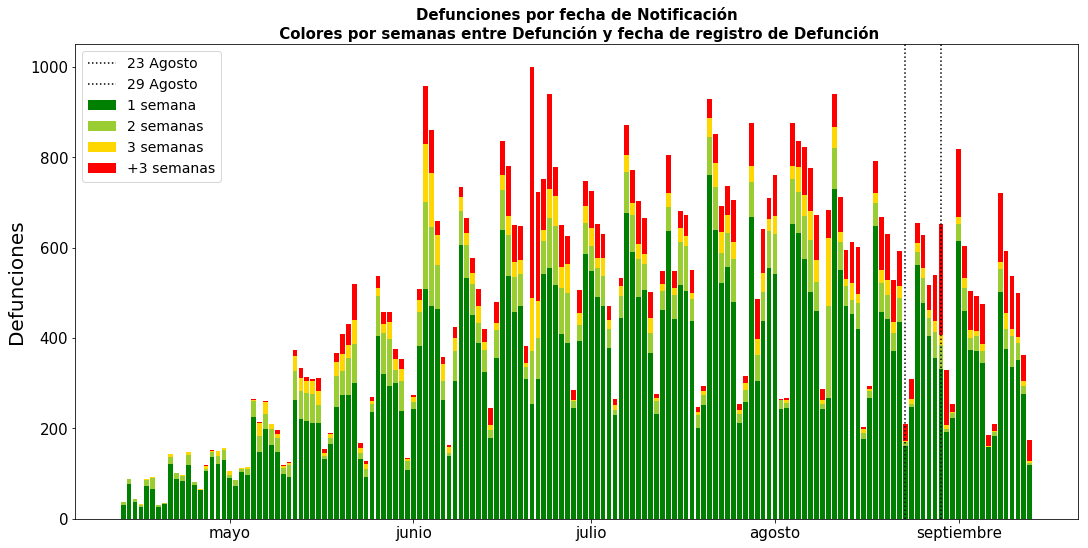

'Spanish_Mexico.1252'

In [43]:
locale.setlocale(locale.LC_ALL, 'es-MX')
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(1, 1, figure=fig)

#DEFUNCIONES POR FECHA DE NOTIFICACIÓN DE DEFUNCIÓN

y5=def_covid_T3["1 semana"]
y6=def_covid_T3["2 semana"]
y7=def_covid_T3["3 semanas"]
y8=def_covid_T3["+3 semanas"]

aux_y5y6=np.add(def_covid_T3["1 semana"],def_covid_T3["2 semana"]).tolist()
aux_y5y6y7=np.add(aux_y5y6,def_covid_T3["3 semanas"]).tolist()


x5=def_covid_T3["R3_FECHA"]

ax5 = fig.add_subplot(gs[0, 0])

ax5.bar(x5,y5,color="green",label="1 semana")
ax5.bar(x5,y6,color="yellowgreen",bottom=y5,label="2 semanas")
ax5.bar(x5,y7,color="gold",bottom=aux_y5y6,label="3 semanas")
ax5.bar(x5,y8,color="red",bottom=aux_y5y6y7,label="+3 semanas")

ax5.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax5.xaxis.set_major_locator(mdates.MonthLocator())
ax5.set_ylabel("Defunciones", fontsize=20)
ax5.tick_params(labelsize=15)

ax5.set_title("Defunciones por fecha de Notificación" +
              "\n Colores por semanas entre Defunción y fecha de registro de Defunción", fontsize=15, weight="bold")

ax5.axvline(x="23-08-2020",color="black",label="23 Agosto",linestyle=":")
ax5.axvline(x="29-08-2020",color="black",label="29 Agosto",linestyle=":")

ax5.legend(fontsize=14)

plt.savefig("Images/Notificación_Atraso_Notificación.png")

plt.show()
locale.setlocale(locale.LC_ALL, "") 

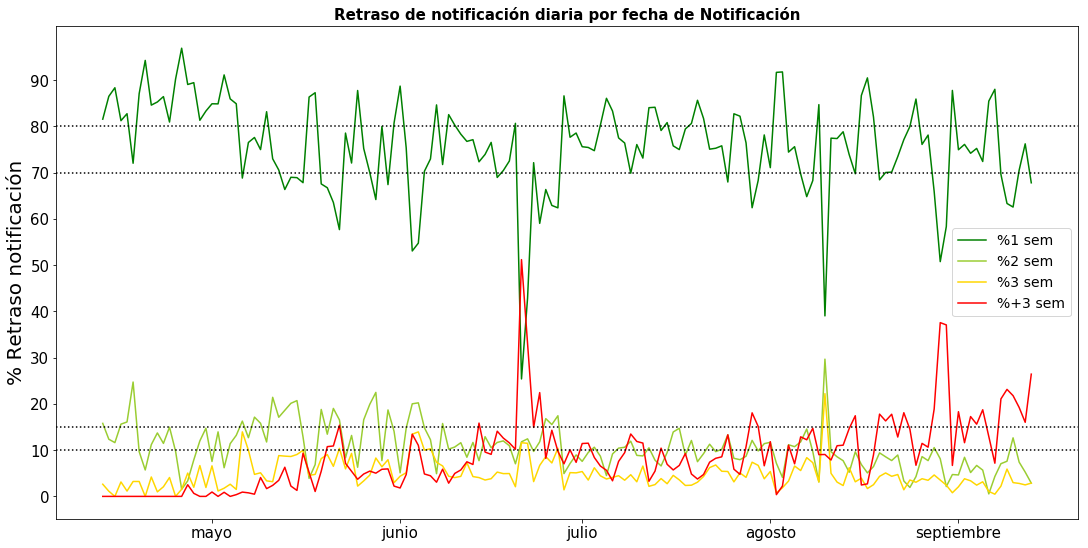

'Spanish_Mexico.1252'

In [82]:
locale.setlocale(locale.LC_ALL, 'es-MX')
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(1, 1, figure=fig)


#DEFUNCIONES POR FECHA DE REGISTRO DEL CASO
y1=def_covid_T3["%1 sem"]
y2=def_covid_T3["%2 sem"]
y3=def_covid_T3["%3 sem"]
y4=def_covid_T3["%+3 sem"]

x1=def_covid_T3["R3_FECHA"]

ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(x1,y1,color="green")#,label="0 - 3 Días; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_0_3)))
ax1.plot(x1,y2,color="yellowgreen")#,label="4 - 7; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_4_7)))
ax1.plot(x1,y3,color="gold")#,label="8 - 14; Mortalidad acumulada: " + str("{:.2%}".format(prom_mort_T1_8_14)))
ax1.plot(x1,y4,color="red")#,label="15+; Mortalidad acumulada: "+str("{:.2%}".format(prom_mort_T1_15)))

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.set_ylabel("% Retraso notificación", fontsize=20)
ax1.tick_params(labelsize=15)
plt.yticks(np.arange(0, 100, 10))

ax1.set_title("Retraso de notificación diaria por fecha de Notificación", fontsize=15, weight="bold")

ax1.axhline(y=70,color="black",linestyle=":")
ax1.axhline(y=80,color="black",linestyle=":")
ax1.axhline(y=10,color="black",linestyle=":")
ax1.axhline(y=15,color="black",linestyle=":")
#ax1.axvline(x="18-08-2020",color="black",label="29 Agosto",linestyle=":")
#ax1.text(primer_reporte, 6000, '  Primer Reporte: ' + str(positivos_R1)+ " casos positivos reportados.")
#ax1.text(primer_reporte, 5500," De los casos pendientes en el primer reporte,") 
#ax1.text(primer_reporte, 5000, str(positivos_R2-positivos_R1)+" casos resultaron positivos")

ax1.legend(fontsize=14)

plt.savefig("Images/Porcentaje_Notificación_Atraso_Notificación.png")

plt.show()
locale.setlocale(locale.LC_ALL, "") 

In [93]:
sem_epid=["27 Vs 26","28 Vs 27","29 Vs 28","30 Vs 29","31 Vs 30","32 Vs 31","33 Vs 32","34 Vs 33","35 Vs 34"]
cambio_dom=[-45,-54,-55,-54,-58,-57,-59,-56,-57]
cambio_sab=[-16,-30,-32,-27,-36,-38,-34,-30,-34]

In [55]:
def_sem_26=Rx.loc[(Rx["FECHA_DEF"]>="2020-06-21")&(Rx["FECHA_DEF"]<="2020-06-27")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_27=Rx.loc[(Rx["FECHA_DEF"]>="2020-06-28")&(Rx["FECHA_DEF"]<="2020-07-04")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_28=Rx.loc[(Rx["FECHA_DEF"]>="2020-07-05")&(Rx["FECHA_DEF"]<="2020-07-11")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_29=Rx.loc[(Rx["FECHA_DEF"]>="2020-07-12")&(Rx["FECHA_DEF"]<="2020-07-18")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_30=Rx.loc[(Rx["FECHA_DEF"]>="2020-07-19")&(Rx["FECHA_DEF"]<="2020-07-25")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_31=Rx.loc[(Rx["FECHA_DEF"]>="2020-07-26")&(Rx["FECHA_DEF"]<="2020-08-01")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_34=Rx.loc[(Rx["FECHA_DEF"]>="2020-08-16")&(Rx["FECHA_DEF"]<="2020-08-22")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]
def_sem_35=Rx.loc[(Rx["FECHA_DEF"]>="2020-08-23")&(Rx["FECHA_DEF"]<="2020-08-29")&(Rx["RX_RESULTADO"]=="Positivo SARS-CoV-2"),["ID_REGISTRO"]].count()[0]

print("Defunciones Semana 26: "+str(def_sem_26)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 27: "+str(def_sem_27)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 28: "+str(def_sem_28)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 29: "+str(def_sem_29)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 30: "+str(def_sem_30)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 31: "+str(def_sem_31)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 32: "+str(def_sem_32)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 33: "+str(def_sem_33)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 34: "+str(def_sem_34)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Defunciones Semana 35: "+str(def_sem_35)+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 27/26: " + str("{:.2%}".format(def_sem_27/def_sem_26-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 28/27: " + str("{:.2%}".format(def_sem_28/def_sem_27-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 29/28: " + str("{:.2%}".format(def_sem_29/def_sem_28-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 30/29: " + str("{:.2%}".format(def_sem_30/def_sem_29-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 31/30: " + str("{:.2%}".format(def_sem_31/def_sem_30-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 32/31: " + str("{:.2%}".format(def_sem_32/def_sem_31-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 33/32: " + str("{:.2%}".format(def_sem_33/def_sem_32-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 34/33: " + str("{:.2%}".format(def_sem_34/def_sem_33-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")
print("Cambio número defunciones Sem 35/34: " + str("{:.2%}".format(def_sem_35/def_sem_34-1))+" (hasta el reporte del "+fecha_ultimo_reporte+")")

Defunciones Semana 26: 3995 (hasta el reporte del 2020-09-13)
Defunciones Semana 27: 4203 (hasta el reporte del 2020-09-13)
Defunciones Semana 28: 4527 (hasta el reporte del 2020-09-13)
Defunciones Semana 29: 4443 (hasta el reporte del 2020-09-13)
Defunciones Semana 30: 4385 (hasta el reporte del 2020-09-13)
Defunciones Semana 31: 4120 (hasta el reporte del 2020-09-13)
Defunciones Semana 32: 3957 (hasta el reporte del 2020-09-13)
Defunciones Semana 33: 3495 (hasta el reporte del 2020-09-13)
Defunciones Semana 34: 3164 (hasta el reporte del 2020-09-13)
Defunciones Semana 35: 2784 (hasta el reporte del 2020-09-13)
Cambio número defunciones Sem 27/26: 5.21% (hasta el reporte del 2020-09-13)
Cambio número defunciones Sem 28/27: 7.71% (hasta el reporte del 2020-09-13)
Cambio número defunciones Sem 29/28: -1.86% (hasta el reporte del 2020-09-13)
Cambio número defunciones Sem 30/29: -1.31% (hasta el reporte del 2020-09-13)
Cambio número defunciones Sem 31/30: -6.04% (hasta el reporte del 2020

In [88]:
cambio_act=[(def_sem_27/def_sem_26-1)*100,(def_sem_28/def_sem_27-1)*100,(def_sem_29/def_sem_28-1)*100,
            (def_sem_30/def_sem_29-1)*100,(def_sem_31/def_sem_30-1)*100,(def_sem_32/def_sem_31-1)*100,
            (def_sem_33/def_sem_32-1)*100,(def_sem_34/def_sem_33-1)*100,(def_sem_35/def_sem_34-1)*100]

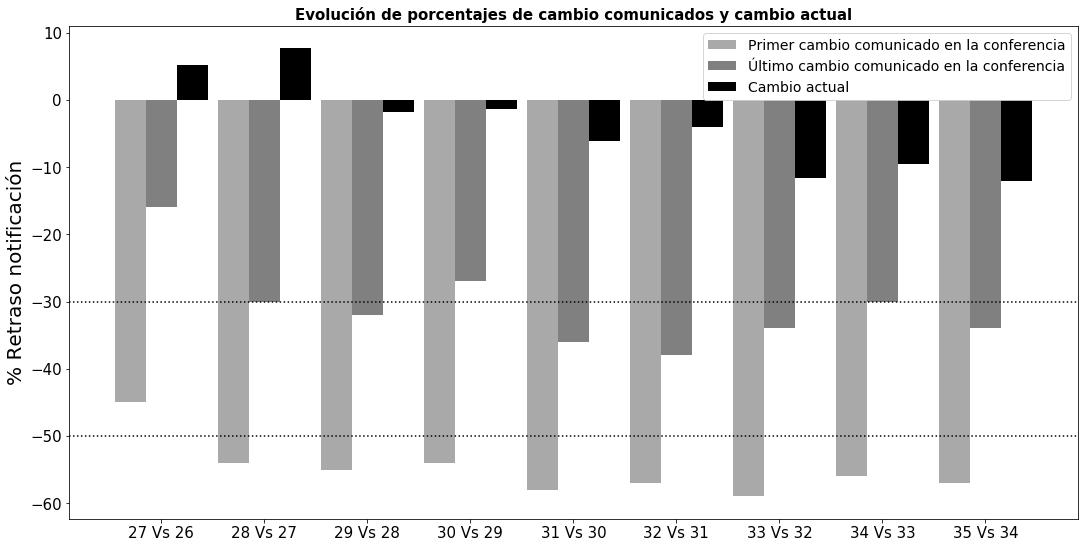

'Spanish_Mexico.1252'

In [96]:
locale.setlocale(locale.LC_ALL, 'es-MX')
fig = plt.figure(constrained_layout=True,figsize=[15,7.5])

gs = GridSpec(1, 1, figure=fig)


#DEFUNCIONES POR FECHA DE REGISTRO DEL CASO

y1=cambio_dom
y2=cambio_sab
y3=cambio_act

x1=sem_epid

N=9
ind = np.arange(N)
locs = np.arange(len(x1))
width = 1.2

ax1 = fig.add_subplot(gs[0, 0])

ax1.bar(locs - width/4,y1,color="darkgrey", width=0.3, label="Primer cambio comunicado en la conferencia")
ax1.bar(locs,y2,color="grey", width=0.3, label="Último cambio comunicado en la conferencia")
ax1.bar(locs + width/4,y3,color="black", width=0.3, label="Cambio actual")

ax1.set_ylabel("% Retraso notificación", fontsize=20)
ax1.tick_params(labelsize=15)
plt.xticks(ind,sem_epid)

ax1.set_title("Evolución de porcentajes de cambio comunicados y cambio actual", fontsize=15, weight="bold")

ax1.axhline(y=-50,color="black",linestyle=":")
ax1.axhline(y=-30,color="black",linestyle=":")

ax1.legend(fontsize=14)

plt.savefig("Images/Evolución_porcentajes_cambios.png")

plt.show()
locale.setlocale(locale.LC_ALL, "") 